<a href="https://colab.research.google.com/github/visgraf/syntheticlearning/blob/main/notebooks/SyntheticDataObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  import datasetinsights
except ModuleNotFoundError:
  ! pip install datasetinsights

In [3]:
import os
import numpy as np
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

from PIL import Image
from PIL import ImageDraw

In [4]:
from datasetinsights.datasets.unity_perception import Captures

# Preparing Dataset

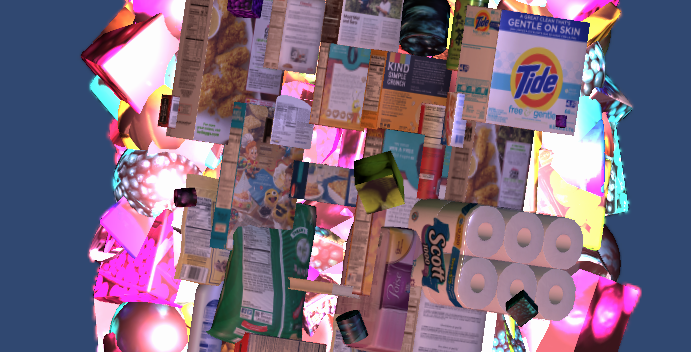

In [5]:
# Update with your paths
DATA_PATH = "/content/drive/MyDrive/datasets/d7a1a125-192b-49cc-ba04-d9dcf175efd4"
IMAGES_PATH = os.path.join(DATA_PATH, "RGB2622bb49-12c1-416a-8c78-ede7a767e763") 
ANNOT_PATH = os.path.join(DATA_PATH, "Datasetc3220d86-d46a-4ac0-a54b-0a5981a69940")
# show an example
image = Image.open(os.path.join(IMAGES_PATH, "rgb_1000.png"))
image

In [6]:
captures = Captures(data_root=ANNOT_PATH)

In [7]:
captures.captures.head(3)

,id,sequence_id,step,timestamp,sensor,ego,filename,format,annotations
0,d06b0378-3881-40ce-a3fa-fae0b5ec6855,8a33a538-8765-421f-9eea-1ca1304d06c7,0,0.0,{'sensor_id': '78f1e1ad-e927-49df-a7aa-95a2aa0...,{'ego_id': 'e2cf4315-e22a-48a2-8cea-14a6604526...,RGB2622bb49-12c1-416a-8c78-ede7a767e763/rgb_2.png,PNG,[{'id': '434fab7d-1028-4da8-a057-d07d59eb0ca4'...
1,47ba9886-6068-4e08-8cf3-af4313683980,717d2c0f-1466-4b82-9c42-e2d5eb9792ca,0,0.0,{'sensor_id': '78f1e1ad-e927-49df-a7aa-95a2aa0...,{'ego_id': 'e2cf4315-e22a-48a2-8cea-14a6604526...,RGB2622bb49-12c1-416a-8c78-ede7a767e763/rgb_3.png,PNG,[{'id': '5c6e92e8-ccc7-413d-b5aa-f41eb453dcb5'...
2,e1e0f645-a401-4e76-90f8-2952244e6b87,64d73f75-7c96-43fd-8d33-094fccfa1bff,0,0.0,{'sensor_id': '78f1e1ad-e927-49df-a7aa-95a2aa0...,{'ego_id': 'e2cf4315-e22a-48a2-8cea-14a6604526...,RGB2622bb49-12c1-416a-8c78-ede7a767e763/rgb_4.png,PNG,[{'id': '120ce271-5a4a-41f5-88fe-e5cedff53bc2'...


In [8]:
captures.annotations.head(3)

,id,annotation_definition,values,capture.id
0,434fab7d-1028-4da8-a057-d07d59eb0ca4,c31620e3-55ff-4af6-ae86-884aa0daa9b2,"[{'label_id': 16, 'label_name': 'cracker_honey...",d06b0378-3881-40ce-a3fa-fae0b5ec6855
1,5c6e92e8-ccc7-413d-b5aa-f41eb453dcb5,c31620e3-55ff-4af6-ae86-884aa0daa9b2,"[{'label_id': 56, 'label_name': 'utensil_coffe...",47ba9886-6068-4e08-8cf3-af4313683980
2,120ce271-5a4a-41f5-88fe-e5cedff53bc2,c31620e3-55ff-4af6-ae86-884aa0daa9b2,"[{'label_id': 19, 'label_name': 'cracker_zwieb...",e1e0f645-a401-4e76-90f8-2952244e6b87


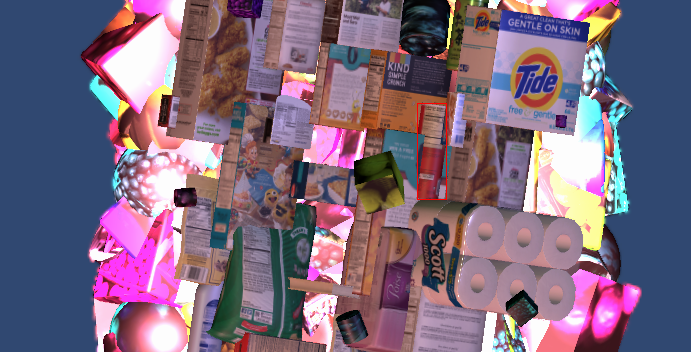

In [9]:
xmin, ymin, xmax, ymax = 417, 103, 417+29, 103+96
draw = ImageDraw.Draw(image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="red")
image

# Preparing DataSet for Pytorch

You may find more info at: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [10]:
def get_annotation_id(df_cap, filename):
  # from captures
  return list(df_cap["annotations"][df_cap.filename == filename])[0][0]['id']

def get_annotation_values(df_annot, id):
  return list(df_annot[df_annot.id == id]["values"])[0]

def mount_box(annot_dict):
  '''Returns box2d coordinates as expected by Faster-RCNN'''
  
  x, y, w, h = annot_dict['x'], annot_dict['y'], annot_dict['width'], annot_dict['height']
  return (x, y, x + w, y + h)

def parse_annotation(filename, df_annotation, df_captures):
  annotation_id = get_annotation_id(df_captures, filename)
  annotation_values = get_annotation_values(df_annotation, annotation_id)
  labels_list, boxes_list  = zip(*[ (value["label_id"], mount_box(value)) for value in annotation_values ])
  
  boxes = torch.as_tensor(boxes_list)
  labels = torch.as_tensor(labels_list, dtype=torch.int64)
  area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

  return {"boxes": boxes, "labels": labels, "area": area}

In [11]:
class SyntheticDataset(torch.utils.data.Dataset):
  def __init__(self, root, df_annot, df_cap, preprocess=None):
    self.root = root
    self.preprocess = preprocess
    self.imgs = sorted(list(captures.captures["filename"]))
    self.annotations = df_annot
    self.captures = df_cap

  def __getitem__(self, idx):
    # load images and bounding boxes
    img_path = os.path.join(self.root, self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    
    target = parse_annotation(self.imgs[idx], self.annotations, self.captures)
    
    num_objs = target["labels"].shape[0]
    image_id = torch.tensor([idx])
    target["image_id"] = image_id
    iscrowd = torch.zeros((num_objs, ), dtype=torch.int64)
    # suppose all instances are not crowd
    target["iscrowd"] = iscrowd

    if self.preprocess is not None:
      img = self.preprocess(img)
    return img, target

  def __len__(self):
    return len(self.imgs)


In [12]:
dataset = SyntheticDataset(DATA_PATH, captures.annotations, captures.captures)

In [13]:
len(dataset)

1000

In [14]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=691x352 at 0x7FC3C7D3C410>,
 {'area': tensor([ 3486.,  1160.,  4650., 10449.,  2646.,   650.,  6225., 11390.,  7276.,
           1260.,  8112., 12028.,  7840.,  9401., 15904., 13377.,  4536., 11625.,
           7031.,  1968.,  8755.,  2352.,  4620., 12100., 11970.,  2862., 16506.,
           1496.,   735., 12928.,  4466.]),
  'boxes': tensor([[434.,   0., 517.,  42.],
          [205.,  13., 245.,  42.],
          [495.,   3., 557.,  78.],
          [237.,   0., 366.,  81.],
          [184.,  64., 233., 118.],
          [543., 100., 569., 125.],
          [367.,  59., 442., 142.],
          [166., 220., 300., 305.],
          [463., 259., 570., 327.],
          [394., 331., 454., 352.],
          [145., 248., 223., 352.],
          [348.,   0., 472.,  97.],
          [285.,  39., 383., 119.],
          [231.,  57., 350., 136.],
          [418.,  67., 560., 179.],
          [216., 108., 363., 199.],
          [317., 137., 389., 200.],
          [138.

# Preparing Model

In [16]:
def get_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # replace pre-trained head with new on
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

def get_transform(augment=False):
  preprocesses = []
  preprocesses.append(transforms.ToTensor())
  if augment:
    preprocesses.append(transforms.RandomHorizontalFlip(0.5))
  return transforms.Compose(preprocesses)

def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
dataset = SyntheticDataset(DATA_PATH, captures.annotations, captures.captures, preprocess=get_transform(True))
dataset_test = SyntheticDataset(DATA_PATH, captures.annotations, captures.captures, preprocess=get_transform(False))

# For this example, we'll split the dataset in train/test data
# However, in practice, it's interesting to use real data as test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-200])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-200:])

In [19]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [20]:
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 1000 examples, 800 are training and 200 testing


# Preparing for the optimization loop

In [29]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'teste'...


In [22]:
from engine import train_one_epoch, evaluate

In [23]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_classes = 64

In [ ]:
model = get_model(num_classes)
model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# learning rate scheduler to decrease the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

  lr_scheduler.step()
  evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/400]  eta: 0:19:04  lr: 0.000018  loss: 5.3694 (5.3694)  loss_classifier: 4.2283 (4.2283)  loss_box_reg: 0.7102 (0.7102)  loss_objectness: 0.3547 (0.3547)  loss_rpn_box_reg: 0.0762 (0.0762)  time: 2.8605  data: 2.0821  max mem: 2282
Epoch: [0]  [ 10/400]  eta: 0:04:50  lr: 0.000143  loss: 5.4121 (5.4096)  loss_classifier: 4.0538 (3.9998)  loss_box_reg: 0.7601 (0.7305)  loss_objectness: 0.5673 (0.5846)  loss_rpn_box_reg: 0.0879 (0.0946)  time: 0.7442  data: 0.2049  max mem: 2550
Epoch: [0]  [ 20/400]  eta: 0:04:03  lr: 0.000268  loss: 4.6201 (4.5591)  loss_classifier: 3.4108 (3.2487)  loss_box_reg: 0.7696 (0.7432)  loss_objectness: 0.4007 (0.4629)  loss_rpn_box_reg: 0.0879 (0.1043)  time: 0.5290  data: 0.0122  max mem: 2550
Epoch: [0]  [ 30/400]  eta: 0:03:44  lr: 0.000393  loss: 3.2035 (4.0705)  loss_classifier: 1.8047 (2.7198)  loss_box_reg: 0.7891 (0.7620)  loss_objectness: 0.3013 (0.4593)  loss_rpn_box_reg: 0.0828 (0.1294)  time: 0.5294  data: 0.0077  max mem: 2550


# Saving trained model

In [25]:
MODEL_DIR = "/content/drive/MyDrive/models"

In [ ]:
torch.save(model.state_dict(), os.path.join(MODEL_DIR, "fr-rcnn-synthetic10"))

# Loading Model

In [26]:
loaded_model = get_model(num_classes)
# yeah, I have another model here...
loaded_model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "fr-rcnn-synthetic50")))

<All keys matched successfully>

### After 50 epochs, the model had the following performance

| Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.566 |
|------------------------------------------|-------------|-----------------------|
| Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.773 |
| Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.662 |
| Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.173 |
| Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.553 |
| Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.701 |
| Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.563 |
| Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.673 |
| Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.673 |
| Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.230 |
| Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.673 |
| Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.744 |

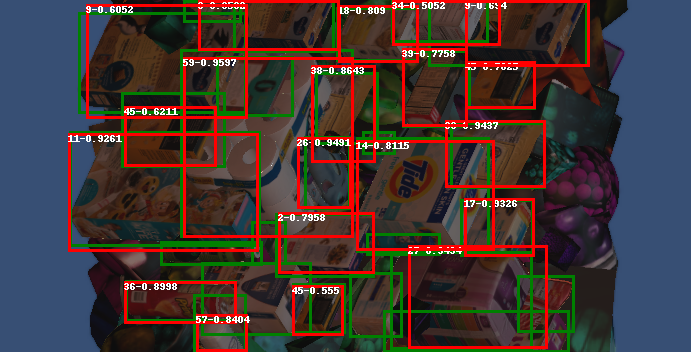

In [27]:
idx = 12
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
labels = np.array(dataset_test[idx][1]["labels"])
# put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# draw groundtruth
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])], 
   outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   label = prediction[0]["labels"][element].cpu().numpy()
   if score > 0.5:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = f"{label}-{str(score)}")
image